El script Main.py opera de forma incremental, agregando nuevos registros a los datasets en formato CSV tras cada ejecución. La presencia de filas duplicadas es intencional y busca aumentar la fiabilidad estadística de los datos mediante la reiteración de pruebas. Cuando un análisis específico requiera un conjunto de datos sin duplicados, se realizará el filtrado correspondiente, indicándolo explícitamente. En este notebook se evaluarán métricas clave como la precisión, la latencia y la exactitud en la atribución de fuentes (Source Attribution Accuracy), entre otras.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import numpy as np

CSV_FILE_FLASH = "gemini-2.5-flash.csv"
CSV_FILE_PRO = "gemini-2.5-pro.csv"

CSV_FILE = CSV_FILE_PRO

MODEL = CSV_FILE.replace(".csv","")
GENERAL_DATAFRAME_PATH = "results.csv"
pipelines_lst = [
                 "baseline",
                 "bm25", 
                 "dense",
                 "hybrid"
                ]

try:
    df = pd.read_csv(CSV_FILE)
    print(f"Loaded {len(df)} records from {CSV_FILE}")
except FileNotFoundError:
    print("CSV file not found. Run main.py")

Loaded 630 records from gemini-2.5-pro.csv


In [2]:
df.head()
#df['score'] = df['score'].astype(bool)
#df = df.rename(columns={'score': 'correct'})
#df = df.drop(columns=['Unnamed: 0'])
#df.to_csv(CSV_FILE,index=False)
#df[df['pipeline'] == 'Baseline (Zero-shot)'].count()

,question_number,pipeline,correct,predicted,ground_truth,quote,source,latency,run_timestamp
0,1.0,Baseline (Zero-shot),True,C,C,No quote provided,NaN,19.179108,2025-12-02 17:03:05
1,2.0,Baseline (Zero-shot),False,A,C,No quote provided,NaN,17.508561,2025-12-02 17:03:05
2,3.0,Baseline (Zero-shot),False,A,B,No quote provided,NaN,19.660866,2025-12-02 17:03:05
3,4.0,Baseline (Zero-shot),True,D,D,No quote provided,NaN,15.667372,2025-12-02 17:03:05
4,5.0,Baseline (Zero-shot),True,C,C,No quote provided,NaN,20.582384,2025-12-02 17:03:05


 #### PREPROCESS: Clean Data for Plotting

In [3]:
df = df.rename(columns={'correct': 'score'})

df['score'] = df['score'].fillna(0).astype(int)
df['score'] = df['score'].astype(int)

df.loc[92:93,:]

,question_number,pipeline,score,predicted,ground_truth,quote,source,latency,run_timestamp
92,23.0,BM25 RAG,1,C,C,"Unlike prior methods (Yen et al., 2024),REFRAG...",filename: 2509.01092v2.pdf page 1,14.745120,2025-12-02 17:24:04
93,24.0,BM25 RAG,1,C,C,The main objectives are to align the encoder a...,filename: 2509.01092v2.pdf page 3,13.210476,2025-12-02 17:24:04


## Accuracy (number of correct answers)

In [4]:
df_flash = pd.read_csv(CSV_FILE_FLASH)
df_pro = pd.read_csv(CSV_FILE_PRO)

df_flash = df_flash.rename(columns={'correct': 'score'})
df_flash['score'] = df_flash['score'].fillna(0).astype(int)
df_flash['score'] = df_flash['score'].astype(int)

df_pro = df_pro.rename(columns={'correct': 'score'})
df_pro['score'] = df_pro['score'].fillna(0).astype(int)
df_pro['score'] = df_pro['score'].astype(int)

stats_flash = df_flash.groupby('pipeline')['score'].mean()
stats_pro = df_pro.groupby('pipeline')['score'].mean()

stats_flash.name = 'flash_acc'  
stats_pro.name = 'pro_acc'  

general_df = pd.concat([stats_flash, stats_pro], axis=1)
general_df

,flash_acc,pro_acc
pipeline,,
BM25 RAG,0.871429,0.906475
Baseline (Zero-shot),0.357143,0.647619
Dense RAG,0.835714,0.847826
Hybrid RAG,0.871429,0.950000


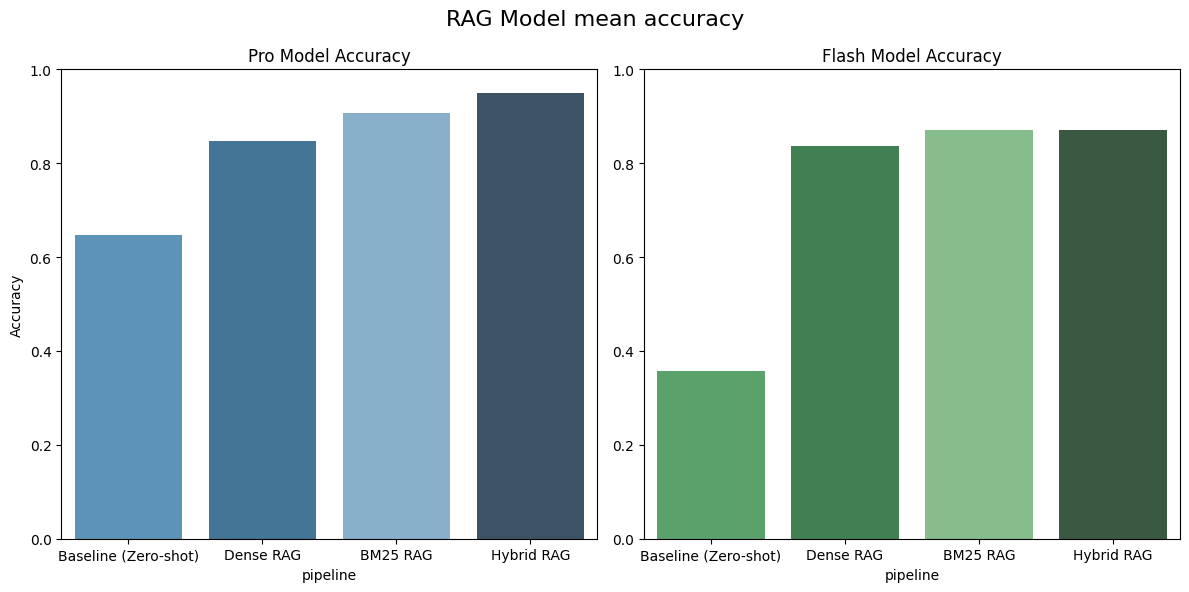

In [5]:
custom_order = ["Baseline (Zero-shot)", "Dense RAG", "BM25 RAG", "Hybrid RAG"]
plot_data = general_df.copy()

# 1. Change to 1 Row, 2 Columns (and reduce width slightly)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('RAG Model mean accuracy', fontsize=16)

# --- CHART 1: PRO Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="pro_acc", 
    hue="pipeline", 
    palette="Blues_d", 
    legend=False, 
    ax=axes[0],
    order=custom_order  
)
axes[0].set_title("Pro Model Accuracy")
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel("Accuracy")

# --- CHART 2: FLASH Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="flash_acc", 
    hue="pipeline", 
    palette="Greens_d", 
    legend=False, 
    ax=axes[1],
    order=custom_order
)
axes[1].set_title("Flash Model Accuracy")
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("") # Hide Y-label for the second chart to look cleaner

plt.tight_layout()
plt.show()

Es curioso que la precisión del Hybrid RAG y el BM25 RAG en el modelo flash sea prácticamente la misma. Se especula que con el modelo flash la cantidad de computación que hace es menor que en el modelo pro y que a causa de ello la parte Dense RAG del Hybrid RAG no es capaz de aportar demasiado. El pro y el flash ambos fueron entrenados con datos de hasta el 17 de junio de 2025, la diferencia entre la precisión probablemente se deba a que el pro es capaz de especular mejor que el flash.

## Latency


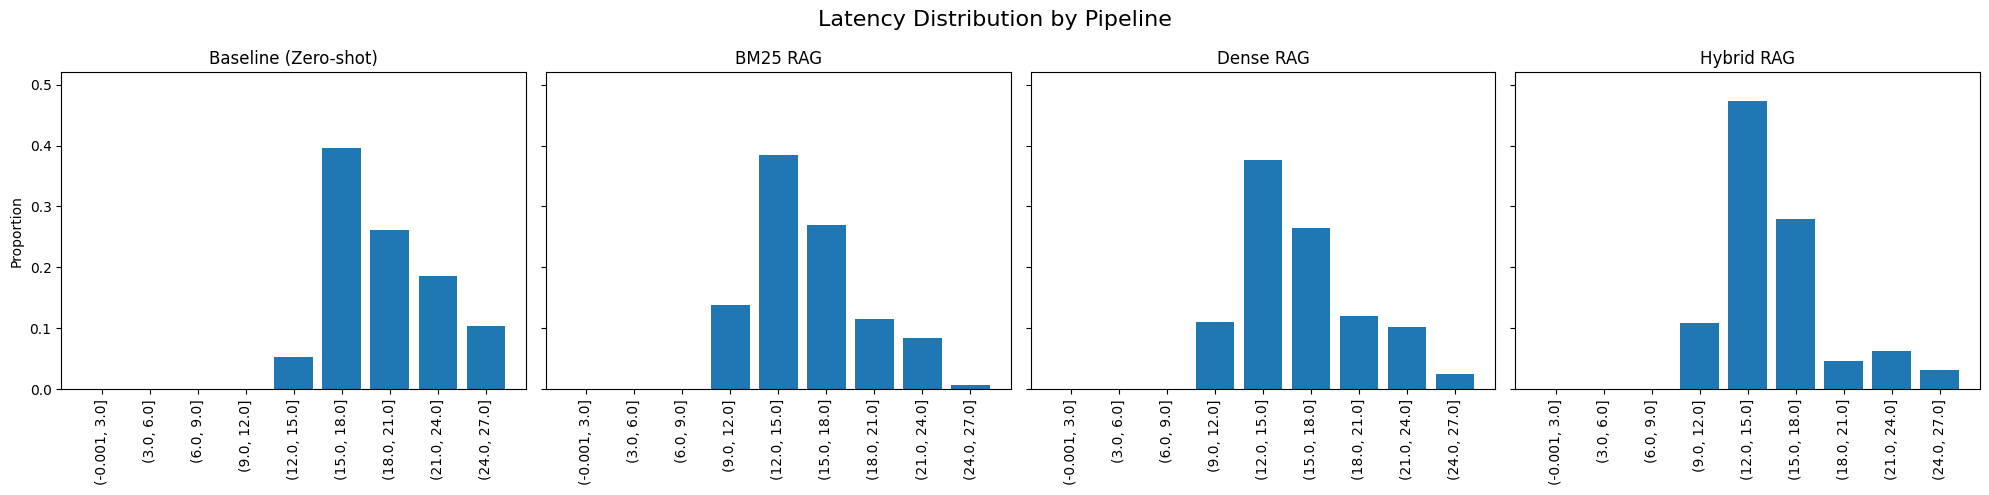

In [22]:
import numpy as np
import matplotlib.pyplot as plt

pipelines = ["Baseline (Zero-shot)", "BM25 RAG", "Dense RAG", "Hybrid RAG"]
plot_data_pro = df_pro.copy()
plot_data_flash = df_flash.copy()

plot_data = plot_data_pro

# Linear bins from 0 to 250 seconds
bins = np.arange(0, 30, 3)  # 10-second intervals
plot_data["latency_bin"] = pd.cut(plot_data["latency"], bins=bins, include_lowest=True)

# Group and normalize per pipeline
binned = (
    plot_data
    .groupby(["pipeline", "latency_bin"], observed=False)
    .size()
    .reset_index(name="count")
)
totals = binned.groupby("pipeline")["count"].transform("sum")
binned["norm"] = binned["count"] / totals

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, p in zip(axes, pipelines):
    dfp = binned[binned["pipeline"] == p]
    ax.bar(dfp["latency_bin"].astype(str), dfp["norm"])
    ax.set_title(p)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, dfp["norm"].max() * 1.1)

axes[0].set_ylabel("Proportion")
fig.suptitle("Latency Distribution by Pipeline", fontsize=16)
plt.tight_layout()
plt.show()

En los gráficos se puede ver que el LLM sin ningún RAG posee mucho mayor tiempo de latencia que el resto. Le sigue Dense RAG, BM25 RAG, siendo el mejor el Hybrid RAG.

In [7]:
summary = plot_data.groupby("pipeline")["latency"].agg(
    mean="mean",
    std="std"
)
summary

,mean,std
pipeline,,
BM25 RAG,17.027074,7.535365
Baseline (Zero-shot),24.225395,14.579285
Dense RAG,20.268658,12.236932
Hybrid RAG,17.674047,10.376437


## Source attribution accuracy, fuzz score and correlation matrix

Se obtiene un merged_df con las referencias en el paper y las citaciones de las diferentes LLMs. No se incluye el baseline LLM porque no procede.

In [8]:
SAA_df = pd.read_csv(CSV_FILE)
SAA_df = SAA_df[SAA_df['pipeline'].isin(['BM25 RAG', 'Dense RAG', 'Hybrid RAG'])]
SAA_df = SAA_df.drop(columns=['predicted','ground_truth','latency','run_timestamp'])

with open("ModelizaciónEmpresaUCMData.json") as f:
    references = json.load(f)

ref_dict = {i + 1: item["paper_reference"] for i, item in enumerate(references)}

ref_df = pd.DataFrame.from_dict(ref_dict, orient='index', columns=['paper_reference'])
ref_df.index.name = 'question_number'
ref_df.reset_index(inplace=True)

merged_df = SAA_df.merge(ref_df, on='question_number', how='left')
merged_df.head()

,question_number,pipeline,correct,quote,source,paper_reference
0,1.0,BM25 RAG,True,By leveraging the inherent sparsity and block-...,"2509.01092v2.pdf, Page: 10",REFRAG makes several novel modifications to th...
1,2.0,BM25 RAG,False,performance of the reconstruction task with an...,"2509.01092v2.pdf, Page: 5",The main objectives are to align the encoder a...
2,3.0,BM25 RAG,True,"However, CEPE is limited to prefix context app...",filename: 2509.01092v2.pdf page 9,"CEPE (Yen et al., 2024) employs cross-attentio..."
3,4.0,BM25 RAG,True,This improvement is attributable to the limite...,filename: 2509.01092v2.pdf page 7,This improvement is attributable to the limite...
4,5.0,BM25 RAG,True,"RAG contexts often contain sparse information,...",filename: 2509.01092v2.pdf page 1,"In RAG, much of the LLM context consists of co..."


#### Obtaining Fuzzscore
Luego se utilizará esta métrica para evaluar el dataset.

In [9]:
from rapidfuzz import fuzz

def verify_quote_accuracy(retrieved_quote, source_text):
    """
    A robust check that handles both exact substrings and jumbled/reordered words.
    """
    # 1. Safety Checks
    if not retrieved_quote or pd.isna(retrieved_quote) or retrieved_quote in ["", "No quote provided"]:
        return 0
    if not source_text or pd.isna(source_text):
        return 0

    # 2. Pre-cleaning (lowercasing is usually enough for RapidFuzz)
    clean_quote = str(retrieved_quote).lower().strip()
    clean_source = str(source_text).lower().strip()
    
    # 3. Calculate Two Scores
    
    # Score A: Strict Order (What you were using)
    # Good for: Verbatim quotes.
    score_strict = fuzz.partial_ratio(clean_quote, clean_source)
    
    # Score B: Flexible Order (The fix)
    # Good for: "95% accuracy" matching "accuracy of 95%"
    # It tokenizes the strings, sorts them, and compares the intersection.
    score_flexible = fuzz.token_set_ratio(clean_quote, clean_source)
    
    # 4. Return the Best Score
    return max(score_strict, score_flexible)

merged_df['quote'] = merged_df['quote'].fillna(" ")

merged_df['fuzz_score'] = merged_df.apply(lambda row: verify_quote_accuracy(row['quote'], row['paper_reference']), axis=1)
merged_df.head()

,question_number,pipeline,correct,quote,source,paper_reference,fuzz_score
0,1.0,BM25 RAG,True,By leveraging the inherent sparsity and block-...,"2509.01092v2.pdf, Page: 10",REFRAG makes several novel modifications to th...,46.586345
1,2.0,BM25 RAG,False,performance of the reconstruction task with an...,"2509.01092v2.pdf, Page: 5",The main objectives are to align the encoder a...,48.936170
2,3.0,BM25 RAG,True,"However, CEPE is limited to prefix context app...",filename: 2509.01092v2.pdf page 9,"CEPE (Yen et al., 2024) employs cross-attentio...",100.000000
3,4.0,BM25 RAG,True,This improvement is attributable to the limite...,filename: 2509.01092v2.pdf page 7,This improvement is attributable to the limite...,100.000000
4,5.0,BM25 RAG,True,"RAG contexts often contain sparse information,...",filename: 2509.01092v2.pdf page 1,"In RAG, much of the LLM context consists of co...",47.967480


#### Obtaining source atribution accuracy

Se utiliza una función presente en la clase Evaluator en main para obtener el SAA. Esta función opera así: se le proporciona el contexto de la página en donde se sitúa la referencia de la pregunta y luego se le pide que compare la citación dada por la LLM + (algún método de RAG) con la referencia y su entorno y que genere el SAA (faithfulness_score).

In [10]:
import main 
from tqdm import tqdm
import google.generativeai as genai
from main import VectorStoreManager, Evaluator, DATASET_PATH

SOURCE_ATRIBUTION_ACCURACY_PATH = "SAA.csv"

if not os.path.exists(SOURCE_ATRIBUTION_ACCURACY_PATH):
    rag_results = merged_df.copy()
    
    V = VectorStoreManager()
    E = Evaluator(DATASET_PATH)
    
    def get_source_text_for_evaluation(quote: str) -> str:
        # Handle cases where quote is None, NaN, or empty
        if not isinstance(quote, str) or not quote.strip(): 
            return ""
        
        clean_quote = quote.replace("\n", " ").strip()
        
        try:
            results = V.search(clean_quote, k=1)
            if results:
                return results[0].page_content
        except Exception as e:
            print(f"Search error: {e}")
            
        return ""
    
    print("Retrieving source text...")
    tqdm.pandas(desc="Retrieving Context")
    rag_results['source_text_for_judge'] = rag_results['quote'].progress_apply(get_source_text_for_evaluation)
    
    print("Evaluating attribution...")
    tqdm.pandas(desc="Checking Faithfulness")
    
    def check_faithfulness(row):
    
        if hasattr(E, 'source_atribution_accuracy'):
            score, reason = E.source_atribution_accuracy(row['quote'], row['source_text_for_judge'])
        else:
            return pd.Series([0.0, "Method not found in Evaluator class"])
            
        return pd.Series([score, reason])
    
    # Apply and Save
    rag_results[['faithfulness_score', 'faithfulness_reasoning']] = rag_results.progress_apply(check_faithfulness, axis=1)
    
    # Display
    rag_results.to_csv("Results.csv")
    rag_results.head()
else:
    rag_results = pd.read_csv(SOURCE_ATRIBUTION_ACCURACY_PATH)

In [11]:
rag_results['faithfulness_score'].mean()
rag_results.to_csv("SAA.csv",index=False)

In [12]:
rag_results[rag_results['pipeline'] == 'Hybrid RAG'].head()

,question_number,pipeline,correct,quote,source,paper_reference,fuzz_score,source_text_for_judge,faithfulness_score,faithfulness_reasoning
277,1.0,Hybrid RAG,True,"It reduces attention computation complexity, w...",filename: 2509.01092v2.pdf page 1,REFRAG makes several novel modifications to th...,100.000000,"in RAG.REFRAGsignificantly reduces latency, TT...",1.0,"The quote is an exact, verbatim extraction fro..."
278,2.0,Hybrid RAG,False,Reconstruction task is essential for the model...,filename: 2509.01092v2.pdf page 5,The main objectives are to align the encoder a...,61.363636,the reconstruction task.\nReconstruction task ...,1.0,"The quote is an exact, verbatim sentence extra..."
279,3.0,Hybrid RAG,True,"However, CEPE is limited to prefix context app...",filename: 2509.01092v2.pdf page 9,"CEPE (Yen et al., 2024) employs cross-attentio...",100.000000,"attention, reducing attention complexity from ...",1.0,"The quote is an exact, verbatim extraction of ..."
280,4.0,Hybrid RAG,True,This improvement is attributable to the limite...,filename: 2509.01092v2.pdf page 7,This improvement is attributable to the limite...,100.000000,"2022), ORConvQA (Qu et al., 2020), and QReCC (...",1.0,"The quote is an exact, verbatim extraction fro..."
281,5.0,Hybrid RAG,True,"In RAG, much of the LLM context consists of co...","2509.01092v2.pdf, Page: 0","In RAG, much of the LLM context consists of co...",100.000000,being uninformative and reused across multiple...,0.8,The quote is not a verbatim or near-verbatim e...


#### Source atribution accuracy representation

En ambos modelos de gemini se ve lo mismo, que el Hybrid RAG es superior al BM25 RAG y este es superior al Dense RAG. 

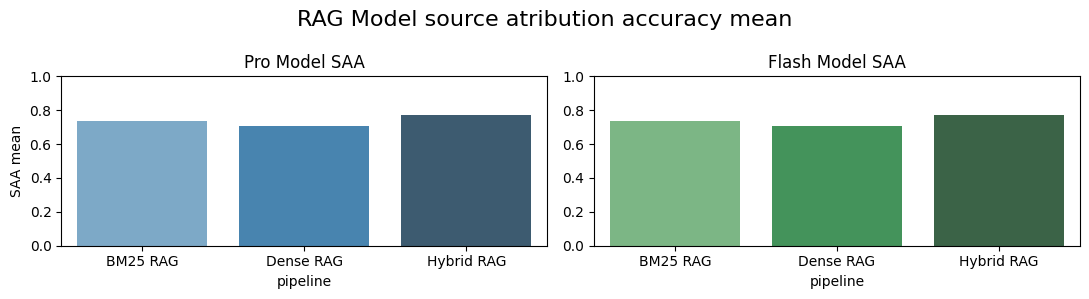

In [13]:
plot_data = rag_results.copy()

fig, axes = plt.subplots(1, 2, figsize=(11, 3))
fig.suptitle('RAG Model source atribution accuracy mean', fontsize=16)

# --- CHART 1: PRO Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="faithfulness_score", 
    hue="pipeline", 
    palette="Blues_d", 
    errorbar=None,
    legend=False, 
    ax=axes[0]
)
axes[0].set_title("Pro Model SAA")
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel("SAA mean")

# --- CHART 2: FLASH Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="faithfulness_score", 
    hue="pipeline", 
    palette="Greens_d", 
    legend=False,
    errorbar=None,
    ax=axes[1]
)
axes[1].set_title("Flash Model SAA")
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("") # Hide Y-label for the second chart to look cleaner

plt.tight_layout()
plt.show()

In [14]:
summary = plot_data.groupby("pipeline")["faithfulness_score"].agg(
    mean="mean",
    std="std"
)
summary

,mean,std
pipeline,,
BM25 RAG,0.736043,0.402596
Dense RAG,0.704493,0.420221
Hybrid RAG,0.773000,0.376511


Se observan las distribuciones del SAA en las diferentes pipelines. Se aprecian dos picos cercanos al 0 y al 1, donde se centran la mayoría de las puntuaciones.

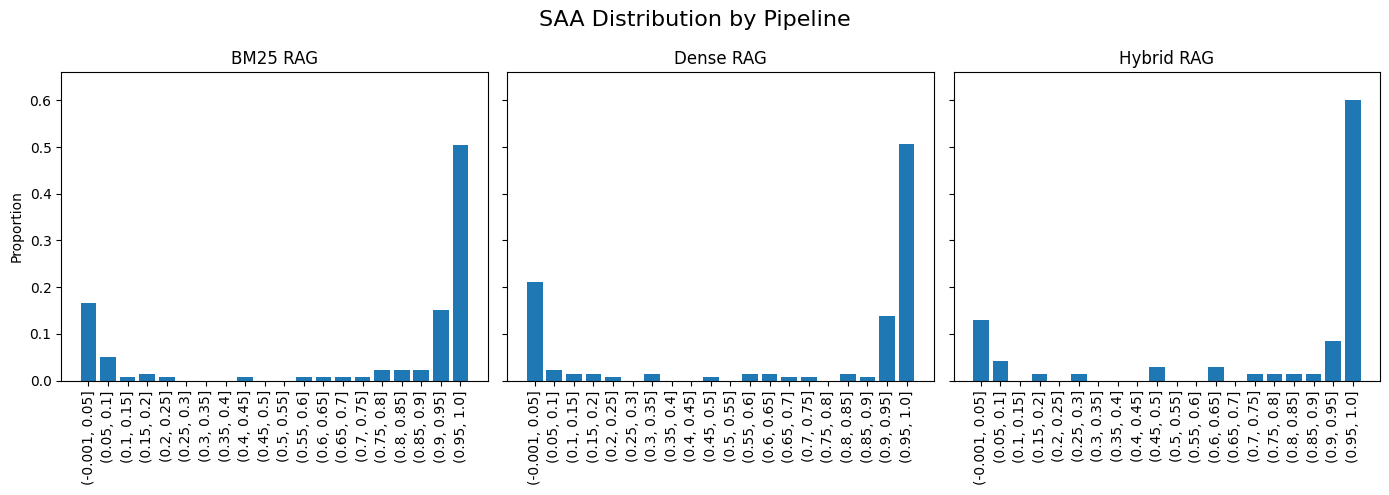

In [15]:
pipelines = ["BM25 RAG", "Dense RAG", "Hybrid RAG"]

bins = np.arange(0, 1.0001, 0.05)
plot_data["bin"] = pd.cut(plot_data["faithfulness_score"], bins=bins, include_lowest=True)

# Raw counts
binned = (
    plot_data
    .groupby(["pipeline", "bin"], observed=False)
    .size()
    .reset_index(name="count")
)

# Normalize within each pipeline
totals = binned.groupby("pipeline")["count"].transform("sum")
binned["norm"] = binned["count"] / totals   # proportions

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for ax, p in zip(axes, pipelines):
    dfp = binned[binned["pipeline"] == p]
    ax.bar(dfp["bin"].astype(str), dfp["norm"])
    ax.set_title(p)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, dfp["norm"].max() * 1.1)
    
fig.suptitle("SAA Distribution by Pipeline", fontsize=16)
axes[0].set_ylabel("Proportion")
plt.tight_layout()
plt.show()

Nota: Los gráficos están normalizados por si hay más datos de una pipeline que de otra

#### Fuzzscore representation

El Fuzz Score cuantifica la similitud léxica entre textos basándose en la distancia de Levenshtein, es decir, el número de ediciones necesarias para transformar una cadena en otra. A priori, cabría esperar que esta métrica favoreciera claramente al BM25 frente al Dense RAG dada su naturaleza de búsqueda exacta. Sin embargo, la superioridad del Hybrid RAG frente al BM25 lleva a una conclusión contraintuitiva: la combinación de búsqueda vectorial y por palabras clave funciona mejor incluso en métricas puramente morfológicas. Esto refuta la hipótesis inicial, sugiriendo que el componente semántico ayuda a filtrar candidatos que, a la postre, resultan tener también una mayor coincidencia textual.


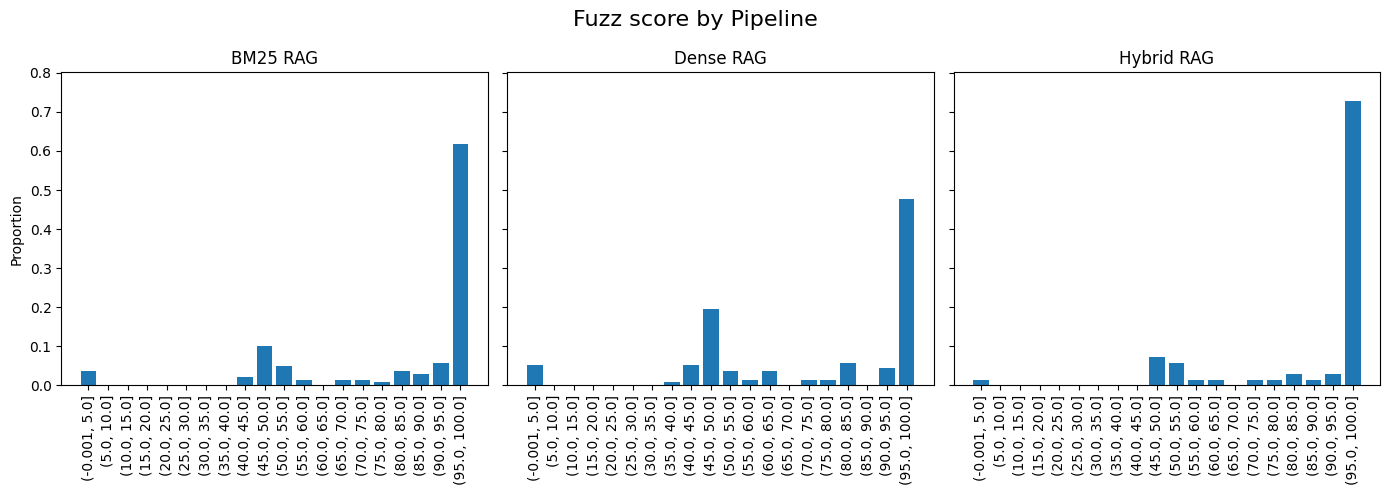

In [16]:
pipelines = ["BM25 RAG", "Dense RAG", "Hybrid RAG"]

bins = np.arange(0, 100.0001, 5)
plot_data["bin"] = pd.cut(plot_data["fuzz_score"], bins=bins, include_lowest=True)

# Raw counts
binned = (
    plot_data
    .groupby(["pipeline", "bin"], observed=False)
    .size()
    .reset_index(name="count")
)

# Normalize within each pipeline
totals = binned.groupby("pipeline")["count"].transform("sum")
binned["norm"] = binned["count"] / totals   # proportions

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for ax, p in zip(axes, pipelines):
    dfp = binned[binned["pipeline"] == p]
    ax.bar(dfp["bin"].astype(str), dfp["norm"])
    ax.set_title(p)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, dfp["norm"].max() * 1.1)
    
fig.suptitle("Fuzz score by Pipeline", fontsize=16)
axes[0].set_ylabel("Proportion")
plt.tight_layout()
plt.show()

Nota: Los gráficos están normalizados por si hay más datos de una pipeline que de otra

#### Correlation matrix

In [19]:
df_matrix = df_pro.pivot_table(
    index='question_number', 
    columns='pipeline', 
    values='score', 
    aggfunc='mean'  # Si hay entradas duplicadas hace la media 
)
df_matrix

pipeline,BM25 RAG,Baseline (Zero-shot),Dense RAG,Hybrid RAG
question_number,,,,
1.0,1.0,1.0,1.0,1.0
2.0,0.0,0.0,0.0,0.0
3.0,1.0,0.0,0.0,1.0
4.0,1.0,1.0,1.0,1.0
5.0,1.0,1.0,1.0,1.0
...,...,...,...,...
66.0,1.0,1.0,1.0,1.0
67.0,1.0,1.0,1.0,1.0
68.0,0.0,1.0,1.0,1.0


In [20]:
corr_matrix = df_matrix.corr()
corr_matrix

pipeline,BM25 RAG,Baseline (Zero-shot),Dense RAG,Hybrid RAG
pipeline,,,,
BM25 RAG,1.000000,0.056841,0.533381,0.715678
Baseline (Zero-shot),0.056841,1.000000,0.214287,0.193228
Dense RAG,0.533381,0.214287,1.000000,0.575531
Hybrid RAG,0.715678,0.193228,0.575531,1.000000


Se observa que la baseline no tiene similitud en sus respuestas con nadie. También se concluye que el Hybrid RAG comparte muchas más respuestas con el BM25 que con el Dense RAG.

## Conclusiones

Antes de comenzar, cabe mencionar que este proyecto utiliza una API gratuita de Google y que es muy probable que todos los resultados mejorarían con un modelo de pago. Los tiempos de latencia no son muy realistas para un proyecto a escala real.

Se ha observado que, utilizando el modelo Flash, la diferencia entre utilizar el BM25 y el Hybrid Retrieval es casi imperceptible, a diferencia de lo que ocurre si se utiliza el modelo Pro. Si se quieren obtener respuestas muy rápidas y baratas no tiene mucho sentido optar por el Hybrid Retrieval, dado que el BM25 ofrece un rendimiento similar. Sin embargo, en cuanto utilizamos más recursos computacionales, se aprecia una diferencia notable entre el Hybrid RAG y el BM25 RAG, la cual se debe al efecto del Dense Retrieval. Este por su cuenta es poco eficaz y ni siquiera puede superar al BM25, pero si se utilizan a la par es posible obtener precisiones muy altas para todas las métricas disponibles.

En cuanto a la Source Attribution Accuracy, en ambos modelos utilizar el Hybrid Retrieval supone una mejora; no tiene sentido optar por cualquiera de las otras dos alternativas. Además, si se observan los gráficos de latencia, con los modelos Pro y Flash se ve que el Hybrid RAG consigue menores tiempos que Dense RAG y BM25 RAG. Por otro lado, el Fuzz Score respalda contundentemente la decisión de utilizar Hybrid RAG. El hecho de que el modelo híbrido se imponga en esta métrica léxica es el argumento definitivo: demuestra que no solo comprende el contexto semántico, sino que es capaz de respetar la terminología exacta mejor que el BM25 por sí solo, combinando así lo mejor de ambos mundos.

En contraposición al Hybrid RAG, las ventajas que tiene el BM25 RAG residen en no necesitar un almacén de vectores y en los pocos recursos que consume. Quizás, si se dispone de pocos recursos computacionales para un proyecto, el BM25 RAG pueda ser una solución temporal antes que implementar el Hybrid RAG, pero cuesta imaginarse un caso en el que pagar la potencia extra no compense el coste con una mejora muy sustancial en todas las métricas.

El Dense Retrieval es inferior en todas las métricas comparado con el BM25. Se atribuye este desempeño al contenido del dataset: se teoriza que la profundidad técnica y el uso de palabras muy especializadas es de gran ayuda para el funcionamiento de BM25. Quizás en un dataset que consista en texto literario, donde la profundidad resida en la semántica y no en la terminología exacta de las palabras, el Dense Retrieval pueda brillar como un método eficaz, aunque esto sea poco probable debido a que el coste de pasar del Dense al Hybrid es muy pequeño.